In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np
import sklearn as sk
from matplotlib import pyplot
from pandas import read_csv
import statsmodels.api as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt

warnings.filterwarnings("ignore")

# Time Series Analysis and Predictive Modeling with SARIMA

## Introduction

In this document, I will demonstrate how to analyze a simple time series and perform predictive analysis using SARIMA. Time series analysis is a crucial technique in various fields, including finance, economics, and engineering, for understanding historical patterns and making future forecasts.

We will start with basic exploratory data analysis (EDA), followed by statistical tests and transformations to prepare the data for modeling. Then, we will introduce ARIMA and SARIMA models, explaining their components and how they help in forecasting.

## ARIMA and SARIMA Models

### ARIMA (AutoRegressive Integrated Moving Average)
ARIMA is a widely used statistical model for time series forecasting. It consists of three components:
- **AutoRegressive (AR) component**: Uses past values to predict future ones.
- **Integrated (I) component**: Differencing is applied to make the time series stationary.
- **Moving Average (MA) component**: Captures the relationship between an observation and the residual errors from previous observations.

The model is represented as ARIMA(p, d, q), where:
- **p**: The number of lag observations included in the model (AR term).
- **d**: The number of times differencing is applied to make the series stationary.
- **q**: The size of the moving average window (MA term).

### SARIMA (Seasonal ARIMA)
SARIMA extends ARIMA by incorporating seasonal components. It is denoted as SARIMA(p, d, q) × (P, D, Q, s), where:
- **P, D, Q** are seasonal counterparts of p, d, and q.
- **s** represents the seasonal cycle length.

This model is particularly useful when dealing with time series data that exhibit seasonality, such as monthly sales, temperature variations, or economic trends.

## Preliminary Calculations
Before applying ARIMA or SARIMA, we will:
1. Visualize the data.
2. Check for stationarity using tests like the **KPSS test**.
3. Apply transformations (e.g., differencing) if necessary.
4. Identify optimal model parameters using autocorrelation plots and Grid Search.

In the next sections, we will implement these steps and build a predictive model using SARIMA.



Nous avons 144 données dans notre dataframe


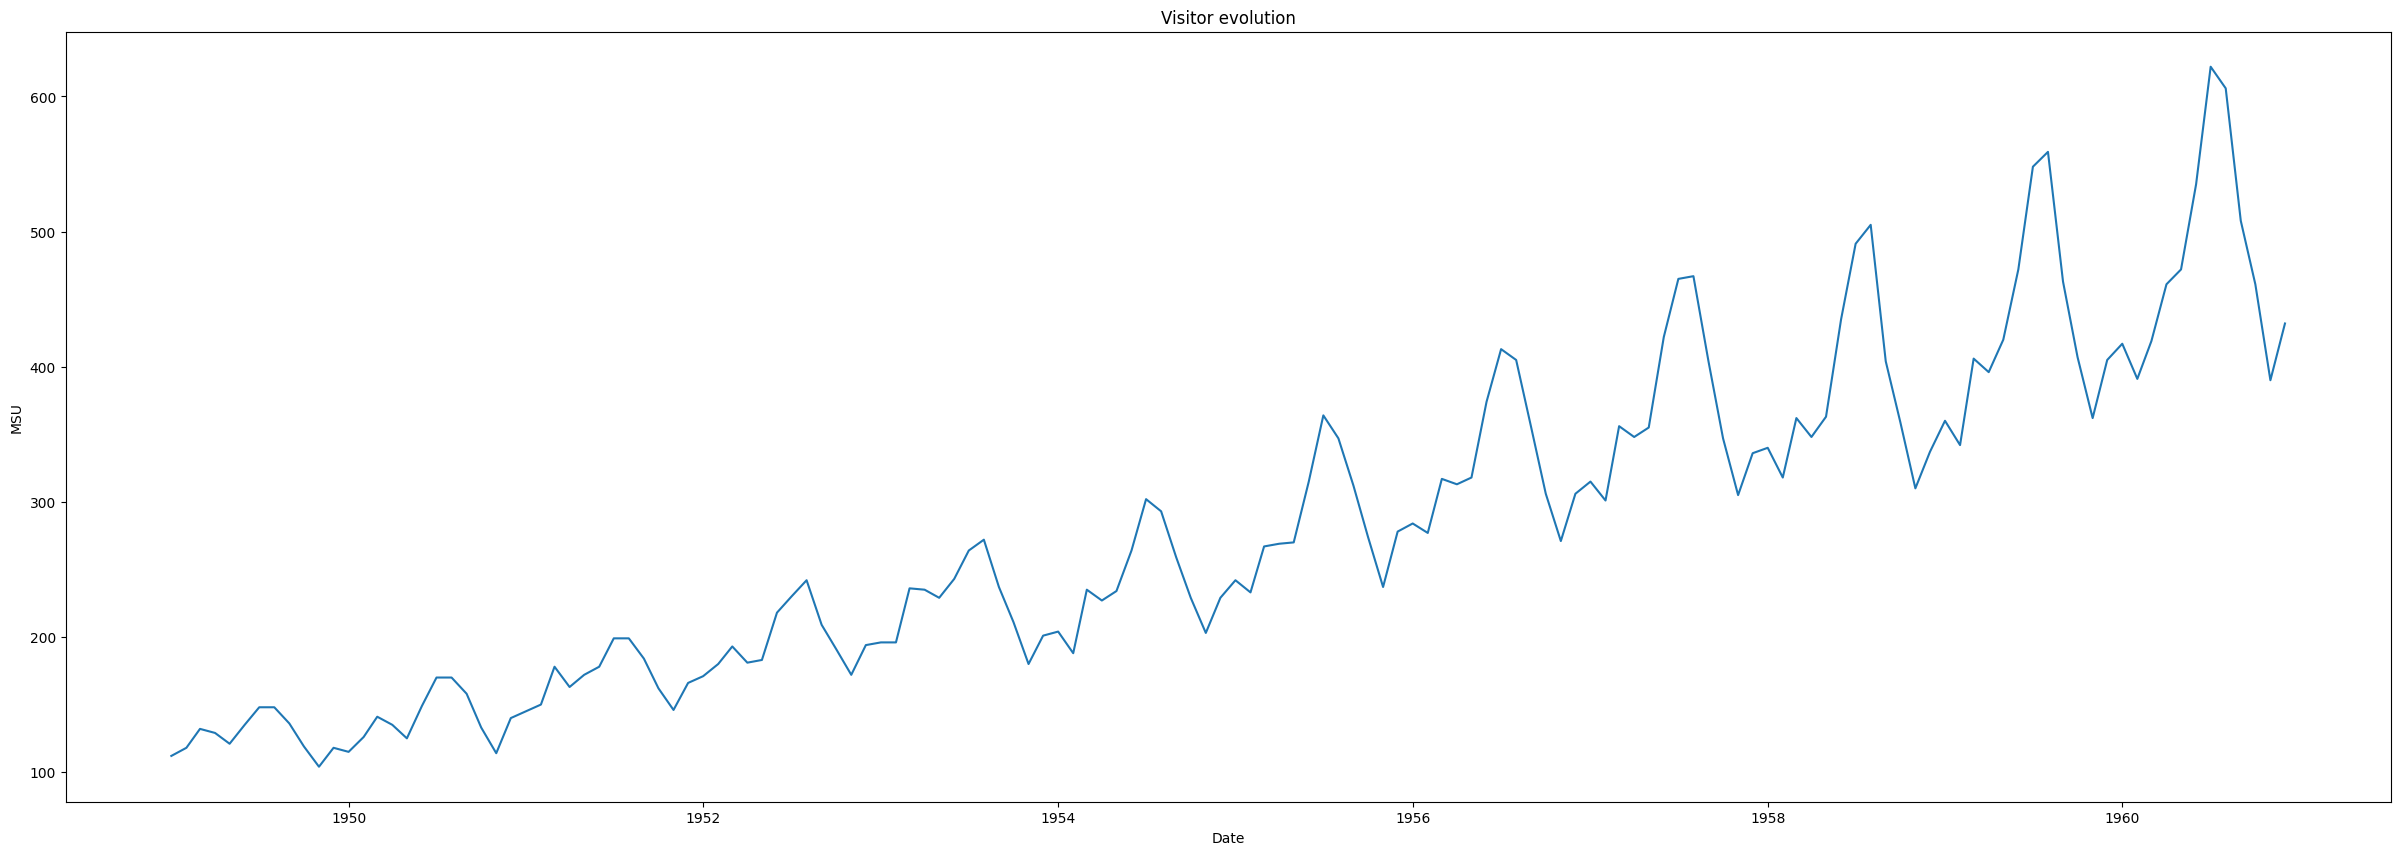

In [135]:
df = read_csv('./cleaned_data.csv', sep=',')
print("Nous avons", len(df), "données dans notre dataframe")
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m') 
df = df.set_index(['DATE'])
plt.figure(figsize=(30, 10))
plt.title('Visitor evolution')
plt.xlabel('Date')
plt.ylabel('MSU')
plt.plot(df)
plt.show()

## Time Series Decomposition Analysis  

When analyzing a time series, we can assume either an **additive** or **multiplicative** decomposition.  

### Additive Decomposition  
If we assume an additive model, the time series can be expressed as:  

$$
Y_t = S_t + T_t + R_t
$$  

where:  
- $ Y_t $ is the observed data at time $ t $,  
- $ S_t $ is the seasonal component,  
- $ T_t $ is the trend-cycle component,  
- $ R_t $ is the remainder (random fluctuations).  

The additive model is appropriate when the seasonal fluctuations or variations around the trend-cycle remain **constant** regardless of the level of the time series.  

### Multiplicative Decomposition  
Alternatively, a **multiplicative model** assumes:  

$$
Y_t = S_t \times T_t \times R_t
$$  

A multiplicative decomposition is more suitable when the **seasonal variations** or **fluctuations around the trend-cycle** are **proportional** to the level of the time series. This is commonly seen in economic and financial data, where seasonal effects tend to increase as the overall values rise.  

### Residuals for Multiplicative Model  

In the case of the **multiplicative model (1st form)**, the difference between the series $ Y_t $ and its adjusted series $ \hat{Y_t} $ represents the residuals:

$$
\epsilon_t = Y_t - \hat{Y_t}
$$

In the case of the **multiplicative model (2nd form)**, the ratio between the series $ Y_t $ and its adjusted series $ \hat{Y_t} $ represents the residuals:

$$
\epsilon_t = \frac{Y_t}{\hat{Y_t}}
$$

**Note:** The only difference between the two multiplicative models is the way $ \epsilon_t $ is calculated.



<Figure size 640x480 with 0 Axes>

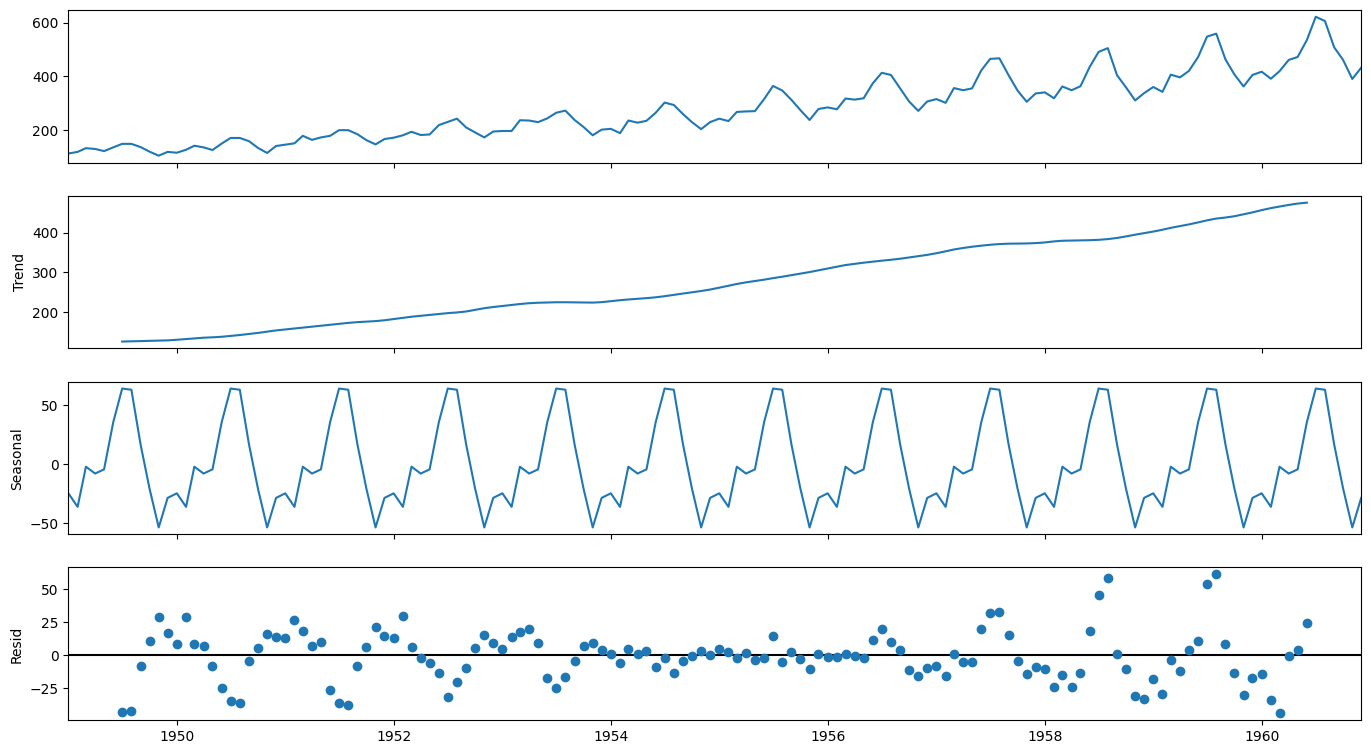

In [125]:
res = sm.tsa.seasonal_decompose(df, model='additive')
fig = plt.figure()  
fig = res.plot()  
fig.set_size_inches(15, 8)
plt.show()

<Figure size 640x480 with 0 Axes>

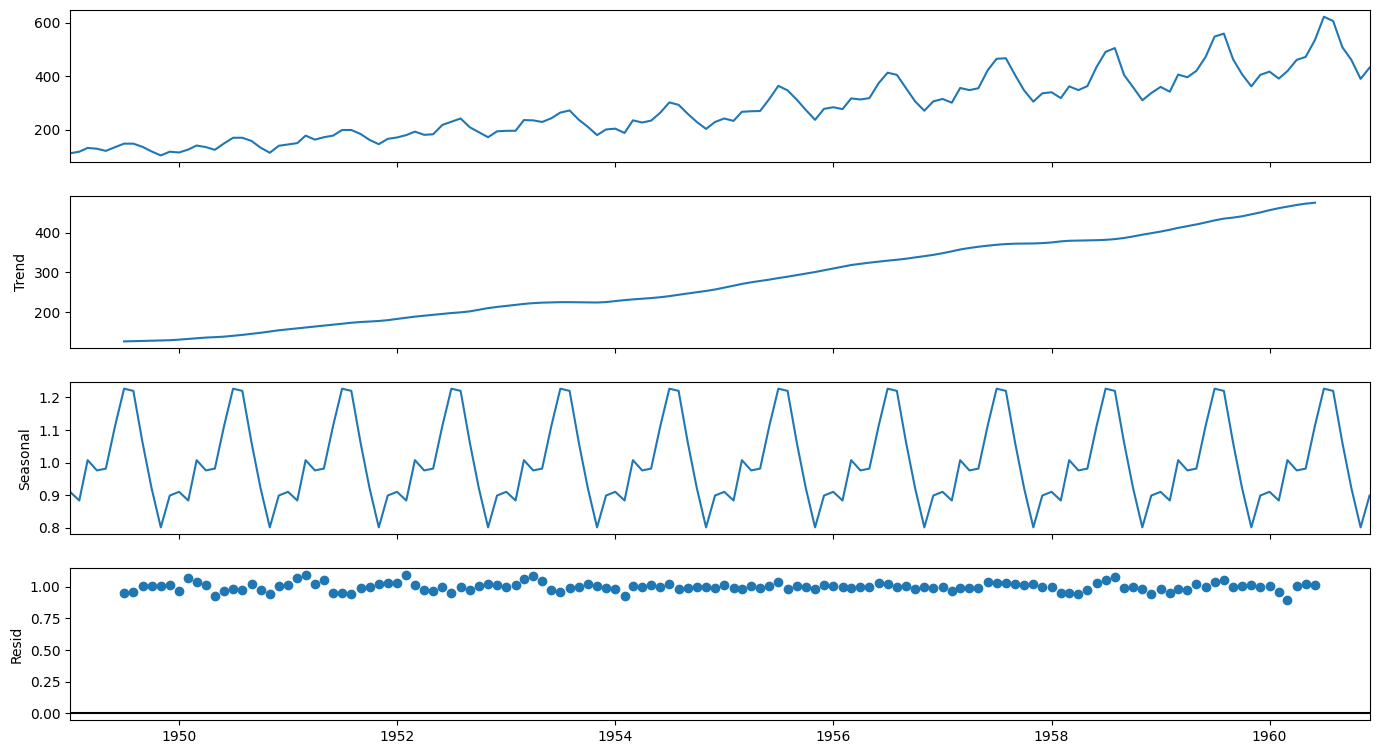

In [126]:
res = sm.tsa.seasonal_decompose(df, model='multiplicative')
fig = plt.figure()  
fig = res.plot()  
fig.set_size_inches(15, 8)
plt.show()

## Checking Stationarity of a Time Series  

### 1. Rolling Mean & Rolling Standard Deviation  
A common approach to check for stationarity is by plotting the **rolling mean** and **rolling standard deviation**. If these values change over time, the series is **non-stationary**.

- **Rolling Mean**:

$$
\text{Rolling Mean} = \frac{1}{n} \sum_{i=t-n}^{t} Y_i
$$

- **Rolling Standard Deviation**:

$$
\text{Rolling Std} = \sqrt{\frac{1}{n} \sum_{i=t-n}^{t} (Y_i - \mu)^2}
$$

Where:
- $ Y_i $ is the observed value,
- $ \mu $ is the mean of the data,
- $ n $ is the window size.

### 2. Augmented Dickey-Fuller (ADF) Test  
The **ADF Test** checks for a unit root, which suggests the series is non-stationary. The null hypothesis $ H_0 $ is that the series has a unit root (non-stationary).

Test statistic:

$$
\Delta Y_t = \alpha + \beta t + \gamma Y_{t-1} + \epsilon_t
$$

Where:
- $ \Delta Y_t $ is the difference between consecutive values,
- $ \alpha $ is a constant,
- $ \beta t $ is a trend term,
- $ \gamma $ is the coefficient to test for a unit root,
- $ \epsilon_t $ is white noise.

### 3. KPSS Test  
The **KPSS Test** is used to test for stationarity around a deterministic trend. The null hypothesis $ H_0 $ is that the series is stationary.

Test statistic:

$$
\hat{\sigma}^2 = \sum_{t=1}^{T} \left( Y_t - \hat{Y}_t \right)^2
$$

Where:
- $ Y_t $ is the observed data,
- $ \hat{Y}_t $ is the estimated trend from the series.

If the p-value from the ADF test is below a threshold (e.g., 0.05), the series is stationary. For KPSS, if the p-value is above the threshold, the series is stationary.

### Summary  
- **Stationary Series**: Rolling mean and standard deviation are constant over time, ADF test p-value is low (reject $ H_0 $), KPSS p-value is high (fail to reject $ H_0 $).
- **Non-Stationary Series**: Rolling statistics change, ADF test p-value is high (fail to reject $ H_0 $), KPSS p-value is low (reject $ H_0 $).


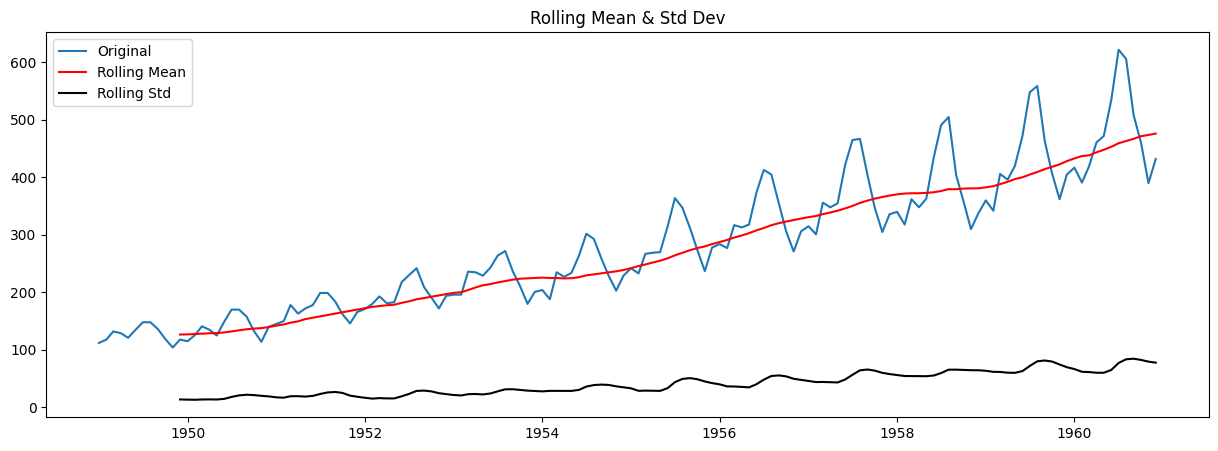

In [127]:
# On va vérifier si la serie temporelle est stationnaire, on va tracer la moyenne mobile et l'écart type

rm = df.rolling(window=12).mean()
rs = df.rolling(window=12).std()

plt.figure(figsize=(15,5))
orig = plt.plot(df, label='Original')
mean = plt.plot(rm, color='red', label='Rolling Mean')
std = plt.plot(rs, color='black', label='Rolling Std')
plt.legend()
plt.title('Rolling Mean & Std Dev')
plt.show()

In [128]:
# Une autre méthode est de faire un test ADF
def adf_check(time_series):
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic',
              'p-value',
              '#Lags Used',
              'Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("La serie est stationnaire")
    else:
        print("La série n'est pas stationnaire ")

timeseries = df['nb_visiteurs']
adf_check(timeseries)

Augmented Dickey-Fuller Test:
ADF Test Statistic : 0.8153688792060482
p-value : 0.991880243437641
#Lags Used : 13
Number of Observations Used : 130
La série n'est pas stationnaire 


In [136]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f"KPSS Statistic: {statistic}")
    print(f"p-value: {p_value}")
    print(f"num lags: {n_lags}")
    print("Critial Values:")
    for key, value in critical_values.items():
        print(f"   {key} : {value}")
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')
    
kpss_test(df)


KPSS Statistic: 1.6513122354165206
p-value: 0.01
num lags: 8
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


## ACF and PACF for AR, MA, and ARIMA Models  

### 1. Autocorrelation Function (ACF)  
The **ACF** measures the correlation between a time series and its lagged versions. It helps to identify the **MA (Moving Average)** component and the overall structure of the model.

ACF Formula:

$$
\rho_k = \frac{\text{Cov}(Y_t, Y_{t-k})}{\text{Var}(Y_t)}
$$

Where:
- **$ \rho_k $** is the autocorrelation at lag **$ k $**,
- **$ \text{Cov}(Y_t, Y_{t-k}) $** is the covariance between **$ Y_t $** and its lagged version **$ Y_{t-k} $**,
- **$ \text{Var}(Y_t) $** is the variance of the time series.

- **For MA Models**: The ACF will typically cut off after a few lags.

### 2. Partial Autocorrelation Function (PACF)  
The **PACF** measures the correlation between the series and its lagged versions, controlling for the effects of intermediate lags. It helps to identify the **AR (Autoregressive)** component.

PACF Formula:

$$
\phi_k = \frac{\text{Cov}(Y_t, Y_{t-k} \mid \text{other lags})}{\text{Var}(Y_t)}
$$

Where:
- **$ \phi_k $** is the partial autocorrelation at lag **$ k $**,
- The covariance is calculated while controlling for the intermediate lags.

- **For AR Models**: The PACF will typically cut off after a few lags.

### 3. AR (Autoregressive) Model  
The **AR(p)** model is based on the autocorrelation at lag **$ p $**, where the current value depends linearly on the previous **$ p $** values.

AR Model Formula:

$$
Y_t = \alpha + \sum_{i=1}^{p} \phi_i Y_{t-i} + \epsilon_t
$$

Where:
- **$ Y_t $** is the observed value,
- **$ \phi_i $** are the coefficients of the autoregressive terms,
- **$ p $** is the number of lags considered,
- **$ \epsilon_t $** is white noise.

### 4. MA (Moving Average) Model  
The **MA(q)** model is based on the autocorrelation at lag **$ q $**, where the current value depends linearly on the residual errors from the previous **$ q $** observations.

MA Model Formula:

$$
Y_t = \mu + \sum_{i=1}^{q} \theta_i \epsilon_{t-i} + \epsilon_t
$$

Where:
- **$ Y_t $** is the observed value,
- **$ \theta_i $** are the coefficients of the moving average terms,
- **$ q $** is the number of lags considered for the errors,
- **$ \epsilon_t $** is white noise.

### 5. ARIMA (Autoregressive Integrated Moving Average) Model  
The **ARIMA(p, d, q)** model combines AR, differencing, and MA to model time series with trends.

ARIMA Model Formula:

$$
\Phi(B) (1 - B)^d Y_t = \Theta(B) \epsilon_t
$$

Where:
- **$ \Phi(B) $** is the autoregressive polynomial of order **$ p $**,
- **$ (1 - B)^d $** represents the differencing operator of order **$ d $**,
- **$ \Theta(B) $** is the moving average polynomial of order **$ q $**,
- **$ \epsilon_t $** is white noise.


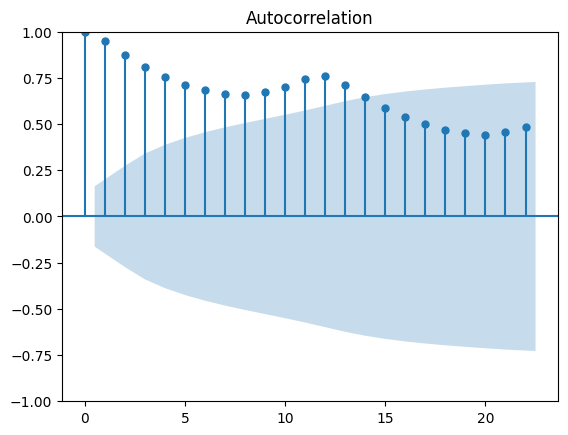

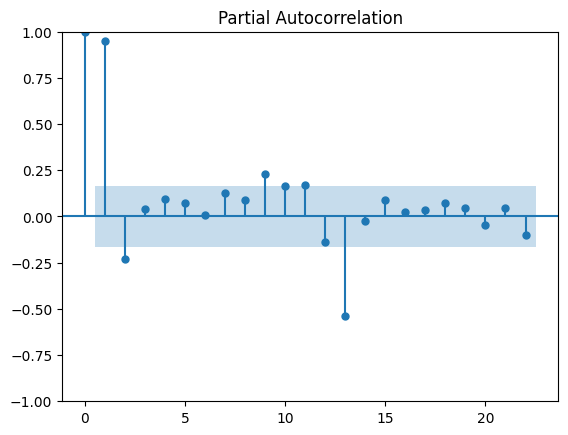

In [137]:
plot_acf(df)
plot_pacf(df)
plt.show()

In [142]:
df["nb_visiteurs_diff"] = df["nb_visiteurs"].diff()  # Différenciation simple
# Vérifier à nouveau avec Dickey-Fuller
result = adfuller(df["nb_visiteurs_diff"].dropna())

print(f"Nouvelle p-value : {result[1]}")
kpss_test(df["nb_visiteurs_diff"].dropna())

Nouvelle p-value : 0.0542132902838255
KPSS Statistic: 0.023897614400183967
p-value: 0.1
num lags: 7
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


<Axes: xlabel='DATE'>

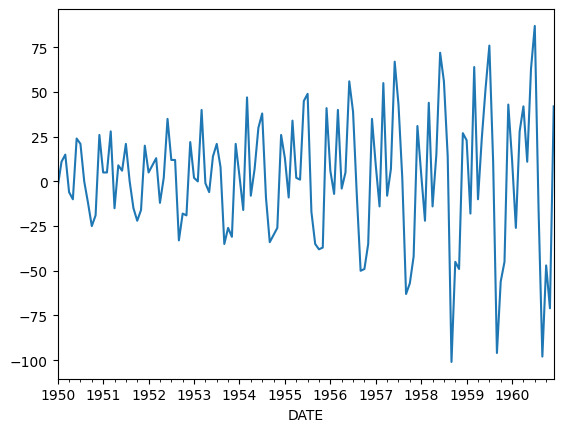

In [150]:
df.head(10)
df = df.dropna()
df["nb_visiteurs_diff"].plot()


<Figure size 640x480 with 0 Axes>

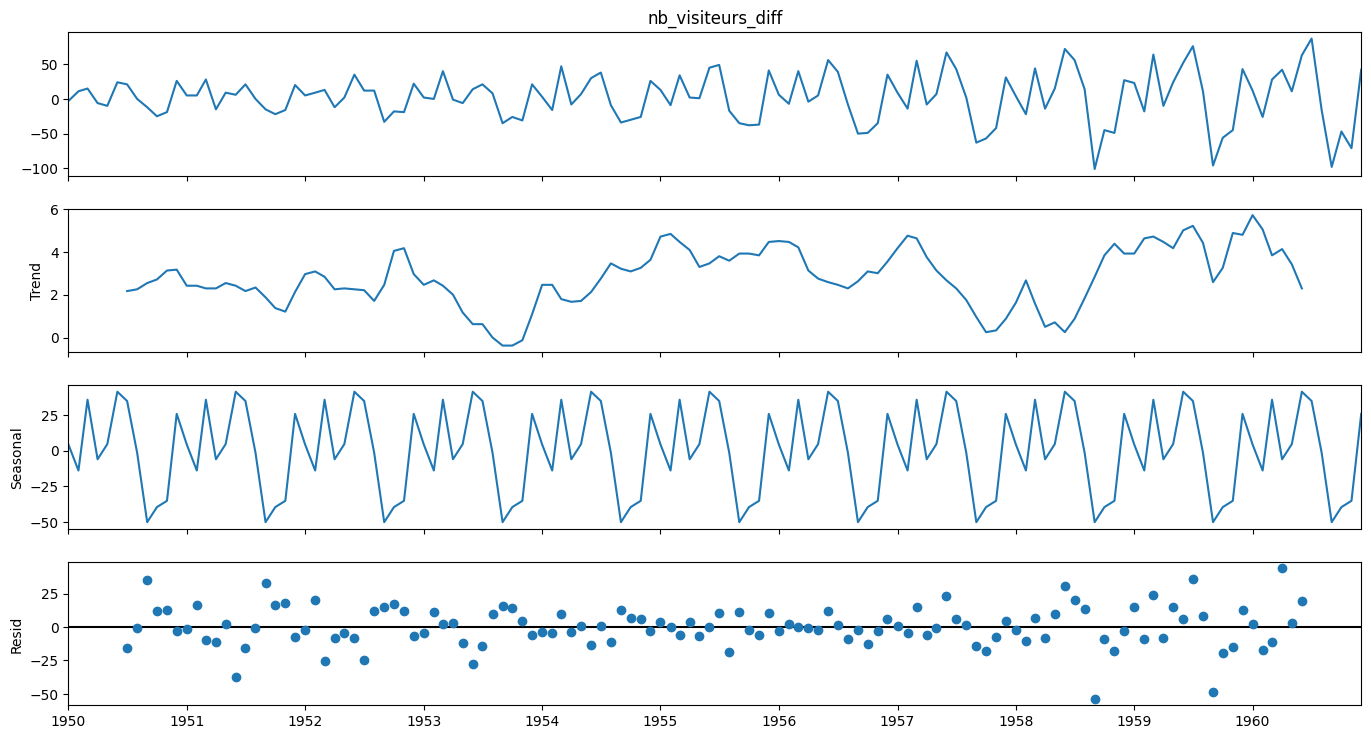

In [152]:
res = sm.tsa.seasonal_decompose(df['nb_visiteurs_diff'])
fig = plt.figure()  
fig = res.plot()  
fig.set_size_inches(15, 8)
plt.show()

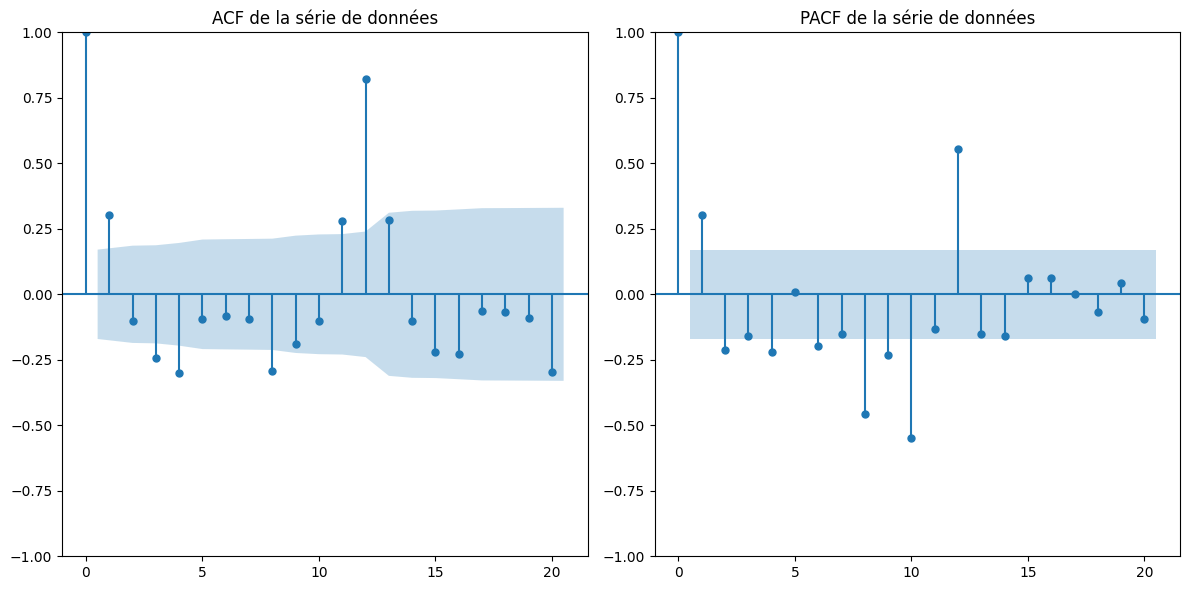

In [155]:
# ACF et PACF pour la série de données
plt.figure(figsize=(12, 6))

# ACF
plt.subplot(121)
plot_acf(df["nb_visiteurs_diff"], lags=20, ax=plt.gca())  # Remplacer par la bonne colonne
plt.title("ACF de la série de données")

# PACF
plt.subplot(122)
plot_pacf(df["nb_visiteurs_diff"], lags=20, ax=plt.gca())  # Remplacer par la bonne colonne
plt.title("PACF de la série de données")

plt.tight_layout()
plt.show()


# ARIMA vs. SARIMA

**ARIMA(p, d, q)** models non-seasonal data:

$$
\phi(B) (1 - B)^d Y_t = \theta(B) \epsilon_t
$$

where \( B \) is the backshift operator.

**SARIMA(p, d, q)(P, D, Q, m)** extends ARIMA with seasonality:

$$
\phi(B) \Phi(B^m) (1 - B)^d (1 - B^m)^D Y_t = \theta(B) \Theta(B^m) \epsilon_t
$$

where \( m \) is the seasonal period.

Use SARIMA when data shows **repeating seasonal patterns**.



RMSE sur les données de test : 49.79239348885086


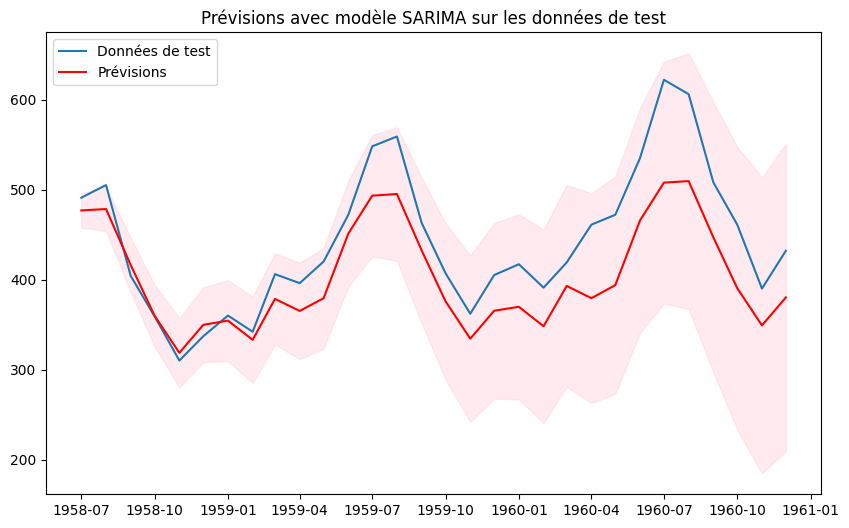

In [156]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Définir une période de test (par exemple, sur les 30 derniers jours)
train_size = len(df) - 30
train_data = df["nb_visiteurs"][:train_size]
test_data = df["nb_visiteurs"][train_size:]

# Ajuster un modèle SARIMA sur les données d'entraînement
sarima_model = SARIMAX(train_data, 
                       order=(1, 1, 1),  # Paramètres ARIMA basés sur l'analyse
                       seasonal_order=(1, 1, 1, 12))  # Saison de 7 jours (hebdomadaire)
sarima_result = sarima_model.fit()

# Faire des prévisions sur les données de test
forecast = sarima_result.get_forecast(steps=30)
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Calculer le RMSE sur les données de test
rmse = np.sqrt(mean_squared_error(test_data, forecast_values))
print(f"RMSE sur les données de test : {rmse}")

# Visualiser les prévisions sur les données de test
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data, label='Données de test')
plt.plot(forecast_values.index, forecast_values, label='Prévisions', color='red')
plt.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('Prévisions avec modèle SARIMA sur les données de test')
plt.show()


## **Grid Search for SARIMA Hyperparameter Selection**

### **Why Use Grid Search?**  
SARIMA models require choosing the best combination of **(p, d, q) x (P, D, Q, s)**.  
Instead of manually testing values, we use **Grid Search** to systematically find the optimal parameters.

---

### **Understanding SARIMA Parameters**
- **(p, d, q):** Non-seasonal ARIMA parameters:
  - **p**: Autoregressive (AR) order – how past values influence the current value.
  - **d**: Differencing order – removes trends to make the series stationary.
  - **q**: Moving Average (MA) order – how past forecast errors impact the current value.
  
- **(P, D, Q, s):** Seasonal components:
  - **P**: Seasonal autoregression.
  - **D**: Seasonal differencing.
  - **Q**: Seasonal moving average.
  - **s**: Seasonal period (e.g., 7 for weekly seasonality).

---

### **How the Grid Search Works**
1. **Define a range** of values for each parameter.
2. **Loop through all possible combinations** using `itertools.product`.
3. **Fit a SARIMA model** for each combination.
4. **Evaluate model performance** using RMSE (Root Mean Squared Error).
5. **Select the best model** (lowest RMSE).

---

### **Key Takeaways**
- Grid Search automates the selection process to find the most accurate SARIMA model.
- The **best model minimizes RMSE**, meaning it has the smallest prediction error.
- This approach prevents manual trial and error and ensures an optimized model.



In [158]:
import itertools

# Plage des hyperparamètres à tester pour SARIMA
p_values = [0, 1, 2, 3]
d_values = [0, 1]
q_values = [0, 1, 2, 3]
seasonal_p = [0, 1, 2]
seasonal_d = [0, 1]
seasonal_q = [0, 1]
seasonal_s = [12]  # Saison de 7 jours

best_rmse = float('inf')
best_order = None
best_seasonal_order = None
best_model = None

# Grid search pour tester les combinaisons d'ordres
for p, d, q in itertools.product(p_values, d_values, q_values):
    for seasonal_order in itertools.product(seasonal_p, seasonal_d, seasonal_q, seasonal_s):
        try:
            # Ajuster un modèle SARIMA avec la combinaison d'hyperparamètres
            model = SARIMAX(train_data, order=(p, d, q), seasonal_order=seasonal_order)
            result = model.fit(disp=False)

            # Faire des prévisions sur les données de test
            forecast = result.get_forecast(steps=30)
            forecast_values = forecast.predicted_mean

            # Calculer le RMSE
            rmse = np.sqrt(mean_squared_error(test_data, forecast_values))
            
            # Si RMSE plus faible, garder ce modèle
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = (p, d, q)
                best_seasonal_order = seasonal_order
                best_model = result

        except Exception as e:
            continue

print(f"Meilleur RMSE: {best_rmse}")
print(f"Meilleur ordre: {best_order}")
print(f"Meilleur ordre saisonnier: {best_seasonal_order}")

Meilleur RMSE: 22.9375690854051
Meilleur ordre: (0, 0, 0)
Meilleur ordre saisonnier: (1, 1, 1, 12)


RMSE sur les données de test : 22.9375690854051


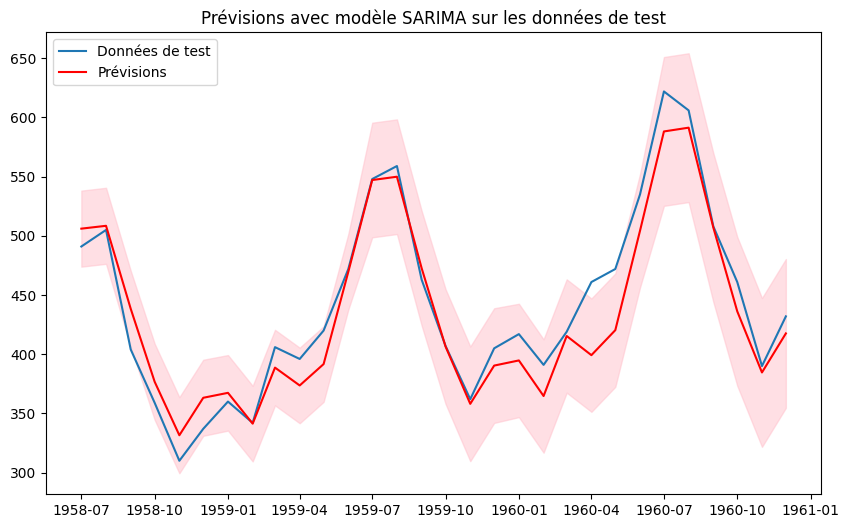

In [159]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Définir une période de test (par exemple, sur les 30 derniers jours)
train_size = len(df) - 30
train_data = df["nb_visiteurs"][:train_size]
test_data = df["nb_visiteurs"][train_size:]

# Ajuster un modèle SARIMA sur les données d'entraînement
sarima_model = SARIMAX(train_data, 
                       order=(0, 0, 0),  # Paramètres ARIMA basés sur l'analyse
                       seasonal_order=(1, 1, 1, 12))  # Saison de 7 jours (hebdomadaire)
sarima_result = sarima_model.fit()

# Faire des prévisions sur les données de test
forecast = sarima_result.get_forecast(steps=30)
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Calculer le RMSE sur les données de test
rmse = np.sqrt(mean_squared_error(test_data, forecast_values))
print(f"RMSE sur les données de test : {rmse}")

# Visualiser les prévisions sur les données de test avec dézoom
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data, label='Données de test')
plt.plot(forecast_values.index, forecast_values, label='Prévisions', color='red')
plt.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.5)

plt.legend()
plt.title('Prévisions avec modèle SARIMA sur les données de test')
plt.show()
